In [1]:
import os
import sys
import glob
import time
import math
import tqdm
from PIL import Image
from collections import OrderedDict

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import extractors

# PSPNet architecture

In [3]:
class PSPModule(nn.Module):
    def __init__(self, features, out_features=1024, sizes=(1, 2, 3, 6)):
        super().__init__()
        self.stages = []
        self.stages = nn.ModuleList([self._make_stage(features, size) for size in sizes])
        self.bottleneck = nn.Conv2d(features * (len(sizes) + 1), out_features, kernel_size=1)
        self.relu = nn.ReLU()

    def _make_stage(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = [F.upsample(input=stage(feats), size=(h, w), mode='bilinear') for stage in self.stages] + [feats]
        bottle = self.bottleneck(torch.cat(priors, 1))
        return self.relu(bottle)


class PSPUpsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

    def forward(self, x):
        h, w = 2 * x.size(2), 2 * x.size(3)
        p = F.upsample(input=x, size=(h, w), mode='bilinear')
        return self.conv(p)


class PSPNet(nn.Module):
    def __init__(self, n_classes=18, sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet34',
                 pretrained=True):
        super().__init__()
        self.feats = getattr(extractors, backend)(pretrained)
        self.psp = PSPModule(psp_size, 1024, sizes)
        self.drop_1 = nn.Dropout2d(p=0.3)

        self.up_1 = PSPUpsample(1024, 256)
        self.up_2 = PSPUpsample(256, 64)
        self.up_3 = PSPUpsample(64, 64)

        self.drop_2 = nn.Dropout2d(p=0.15)
        self.final = nn.Sequential(
            nn.Conv2d(64, n_classes, kernel_size=1),
        )

    def forward(self, x):
        f, class_f = self.feats(x) 
        p = self.psp(f)
        p = self.drop_1(p)

        p = self.up_1(p)
        p = self.drop_2(p)

        p = self.up_2(p)
        p = self.drop_2(p)

        p = self.up_3(p)
        p = self.drop_2(p)
        
        return self.final(p)

In [4]:
net = PSPNet(sizes=(1, 2, 3, 6), n_classes=1, psp_size=512, deep_features_size=256, backend='resnet18')
net.cuda()
print('net compiled')

net compiled


# Unet Architecture

In [5]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        
        return x

In [6]:
#net = UNet(3, 1)
#net.cuda()
#print('net compiled')

# Data loader

In [7]:
def preprocess(img):
    return (img / 255.) * 2. - 1.

def fake_preprocess(img):
    return img / 255.

def res_preprocess(img):
    img = img / 255.
    img[:,:,0] = (img[:,:,0] - 0.406) / 0.225
    img[:,:,1] = (img[:,:,1] - 0.456) / 0.224
    img[:,:,2] = (img[:,:,2] - 0.485) / 0.229
    
    return img

def crop_kek(merged):
    kek_size = 512
    h = np.random.randint(0, 2048 - kek_size)
    w = np.random.randint(0, 2560 - kek_size)
    return merged[h:h+kek_size,w:w+kek_size,:]

In [8]:
class CircuitsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.masks = [os.path.basename(x) for x in glob.glob(root_dir + 'masks/*.npy')]
        self.imgs = [x.split('.npy')[0] + '.png' for x in self.masks]
        
        del_img = []
        del_msk = []
        for image, mask in zip(self.imgs, self.masks):
            if not os.path.exists(self.root_dir + 'imgs/' + image):
                del_img.append(image)
                del_msk.append(mask)
        for i in range(len(del_img)):
            self.masks.remove(del_msk[i])
            self.imgs.remove(del_img[i])

        self.transform = transform
        
    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        img = cv2.imread(root_dir + 'imgs/' + self.imgs[idx]).astype(np.float32)
        img = res_preprocess(img)[:,:,::-1]
        
        with open(root_dir + 'masks/' + self.masks[idx], 'rb') as fp:
            msk = np.load(fp)
        
        combined = np.concatenate([img, msk[:,:,np.newaxis]], axis=2)
        combined = cv2.resize(combined, (512, 512))
        
        if self.transform:
            combined = self.transform.augment_image(combined)

        combined = combined.transpose(2,0,1)
        return combined[:3,:,:], np.expand_dims(combined[3,:,:], axis=0)

In [9]:
import imgaug as ia
from imgaug import augmenters as iaa

In [10]:
sometimes = lambda aug: iaa.Sometimes(0.6, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    sometimes(iaa.Affine(
            scale=(0.6, 1.7),
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval between 0 and 255
    ))
])

In [11]:
root_dir = '/mnt/data/datasets/circuits/'

In [12]:
train_set = CircuitsDataset(root_dir, transform=seq)
train_load = DataLoader(train_set, batch_size=6, shuffle=True, num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 512)
(1, 512, 512)


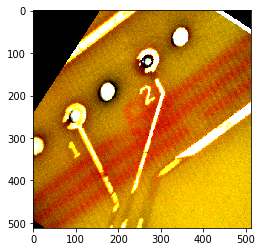

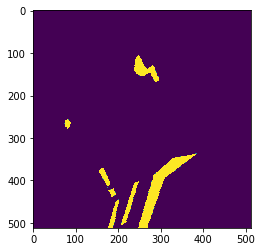

In [13]:
frames, targets = train_set[1]
print(frames.shape)
print(targets.shape)
plt.imshow(frames.transpose(1, 2, 0))
plt.show()
plt.imshow(targets[0,:,:])
plt.show()

# Training

In [14]:
def dice_loss(y_pred, y_true):
    smooth = 1.
    intersection = y_pred * y_true
    int_batch_chnl = torch.sum(torch.sum(intersection, dim=-1), dim=-1)
    pred_batch_chnl = torch.sum(torch.sum(y_pred, dim=-1), dim=-1)
    true_batch_chnl = torch.sum(torch.sum(y_true, dim=-1), dim=-1)

    dice_batch_chnl = (2. * int_batch_chnl + smooth) / (pred_batch_chnl + true_batch_chnl + smooth)

    return -torch.mean(dice_batch_chnl)

In [15]:
optims = optim.Adam(net.parameters())
criter = nn.BCEWithLogitsLoss()

In [16]:
def train_epoch(train_load):
    net.train()
    sum_loss = 0.
    btchs = 0
    for frames, targets in train_load:
        framevar, targvar = frames.cuda(), targets.cuda()
        optims.zero_grad()
        preds = net(framevar)
        loss = criter(preds, targvar) + dice_loss(F.sigmoid(preds), targvar)
        #loss = dice_loss(F.sigmoid(preds), targvar)
        loss.backward()
        optims.step()
        sum_loss += loss.item()
        btchs += 1
    return sum_loss / btchs

def test_epoch(test_load):
    net.eval()
    sum_loss = 0.
    btchs = 0
    for frames, targets in test_load:
        framevar, targvar = frames.cuda(), targets.cuda()
        preds = net(framevar)
        loss = criter(preds, targvar)# + dice_loss(F.sigmoid(preds), targvar)
        sum_loss += loss.data[0]
        btchs += 1
    return sum_loss / btchs

In [17]:
def train_net(n_epochs):
    dirname = '/home/mio/Documents/circuits/snaps'
    
    train_history = []
    test_history  = []
    for i in tqdm.tqdm(range(n_epochs)):
        train_history.append(train_epoch(train_load))
        print('Epoch: {} Loss: {}'.format(i, train_history[-1]))
        #print('testing...')
        #test_history.append(test_epoch(test_load))
        #print('Epoch: {} Loss: {} Test: {}'.format(i, train_history[-1], test_history[-1]))
        torch.save(net.state_dict(), dirname + '/circuits_{}_{}.pth'.format(i, train_history[-1]))
    return train_history#, test_history

In [18]:
tr_loss = train_net(200)

  0%|          | 0/200 [00:00<?, ?it/s]/home/mio/Documents/devpy/lib/python3.7/site-packages/torch/nn/functional.py:1976: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/mio/Documents/devpy/lib/python3.7/site-packages/torch/nn/functional.py:2047: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/mio/Documents/devpy/lib/python3.7/site-packages/torch/nn/functional.py:1047: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|          | 1/200 [01:14<4:07:59, 74.77s/it]

Epoch: 0 Loss: 0.3900901800394058


  1%|          | 2/200 [02:27<4:04:09, 73.99s/it]

Epoch: 1 Loss: 0.1864376562833786


  2%|▏         | 3/200 [03:42<4:04:00, 74.32s/it]

Epoch: 2 Loss: 0.1109883151948452


  2%|▏         | 4/200 [04:57<4:03:05, 74.42s/it]

Epoch: 3 Loss: 0.08900789380073547


  2%|▎         | 5/200 [06:13<4:03:04, 74.79s/it]

Epoch: 4 Loss: 0.08125655449926854


  3%|▎         | 6/200 [07:29<4:02:11, 74.90s/it]

Epoch: 5 Loss: 0.08456159949302673


  4%|▎         | 7/200 [08:44<4:01:02, 74.94s/it]

Epoch: 6 Loss: 0.07721775285899639


  4%|▍         | 8/200 [09:59<3:59:39, 74.89s/it]

Epoch: 7 Loss: 0.08041765794157982


  4%|▍         | 9/200 [11:12<3:58:00, 74.77s/it]

Epoch: 8 Loss: 0.07431476004421711


  5%|▌         | 10/200 [12:27<3:56:43, 74.76s/it]

Epoch: 9 Loss: 0.0696144637465477


  6%|▌         | 11/200 [13:42<3:55:27, 74.75s/it]

Epoch: 10 Loss: 0.05574265509843826


  6%|▌         | 12/200 [14:55<3:53:57, 74.67s/it]

Epoch: 11 Loss: 0.033001349717378614


  6%|▋         | 13/200 [16:10<3:52:46, 74.69s/it]

Epoch: 12 Loss: -0.013657970428466797


  7%|▋         | 14/200 [17:25<3:51:32, 74.69s/it]

Epoch: 13 Loss: -0.047116819322109225


  8%|▊         | 15/200 [18:40<3:50:16, 74.68s/it]

Epoch: 14 Loss: -0.06374254629015923


  8%|▊         | 16/200 [19:54<3:49:00, 74.67s/it]

Epoch: 15 Loss: -0.08305039219558238


  8%|▊         | 17/200 [21:08<3:47:38, 74.64s/it]

Epoch: 16 Loss: -0.09569764509797096


  9%|▉         | 18/200 [22:23<3:46:24, 74.64s/it]

Epoch: 17 Loss: -0.10527641847729682


 10%|▉         | 19/200 [23:38<3:45:10, 74.65s/it]

Epoch: 18 Loss: -0.1046280761808157


 10%|█         | 20/200 [24:53<3:44:01, 74.68s/it]

Epoch: 19 Loss: -0.1107036292552948


 10%|█         | 21/200 [26:09<3:43:00, 74.75s/it]

Epoch: 20 Loss: -0.12732482120394706


 11%|█         | 22/200 [27:25<3:41:56, 74.81s/it]

Epoch: 21 Loss: -0.11578389123082161


 12%|█▏        | 23/200 [28:42<3:40:52, 74.87s/it]

Epoch: 22 Loss: -0.13337366312742233


 12%|█▏        | 24/200 [29:57<3:39:40, 74.89s/it]

Epoch: 23 Loss: -0.13900347098708152


 12%|█▎        | 25/200 [31:08<3:38:02, 74.76s/it]

Epoch: 24 Loss: -0.1439435701072216


 13%|█▎        | 26/200 [32:20<3:36:28, 74.65s/it]

Epoch: 25 Loss: -0.16707427695393562


 14%|█▎        | 27/200 [33:32<3:34:53, 74.53s/it]

Epoch: 26 Loss: -0.172757156342268


 14%|█▍        | 28/200 [34:46<3:33:37, 74.52s/it]

Epoch: 27 Loss: -0.17760685399174692


 14%|█▍        | 29/200 [36:00<3:32:21, 74.51s/it]

Epoch: 28 Loss: -0.18129988998174668


 15%|█▌        | 30/200 [37:15<3:31:06, 74.51s/it]

Epoch: 29 Loss: -0.19578865811228752


 16%|█▌        | 31/200 [38:29<3:29:47, 74.48s/it]

Epoch: 30 Loss: -0.20742639616131783


 16%|█▌        | 32/200 [39:43<3:28:31, 74.47s/it]

Epoch: 31 Loss: -0.2119258724153042


 16%|█▋        | 33/200 [40:58<3:27:21, 74.50s/it]

Epoch: 32 Loss: -0.1906374454498291


 17%|█▋        | 34/200 [42:10<3:25:54, 74.43s/it]

Epoch: 33 Loss: -0.1997035749256611


 18%|█▊        | 35/200 [43:21<3:24:25, 74.33s/it]

Epoch: 34 Loss: -0.2125944060087204


 18%|█▊        | 36/200 [44:34<3:23:04, 74.30s/it]

Epoch: 35 Loss: -0.21635128885507585


 18%|█▊        | 37/200 [45:47<3:21:45, 74.27s/it]

Epoch: 36 Loss: -0.22983475014567376


 19%|█▉        | 38/200 [47:00<3:20:24, 74.22s/it]

Epoch: 37 Loss: -0.2262740983068943


 20%|█▉        | 39/200 [48:12<3:18:59, 74.16s/it]

Epoch: 38 Loss: -0.23423139080405236


 20%|██        | 40/200 [49:23<3:17:35, 74.10s/it]

Epoch: 39 Loss: -0.24493974208831787


 20%|██        | 41/200 [50:37<3:16:18, 74.08s/it]

Epoch: 40 Loss: -0.23048719093203546


 21%|██        | 42/200 [51:49<3:14:58, 74.04s/it]

Epoch: 41 Loss: -0.24860442981123923


 22%|██▏       | 43/200 [53:02<3:13:39, 74.01s/it]

Epoch: 42 Loss: -0.24617168292403221


 22%|██▏       | 44/200 [54:17<3:12:29, 74.04s/it]

Epoch: 43 Loss: -0.2467321202158928


 22%|██▎       | 45/200 [55:32<3:11:18, 74.06s/it]

Epoch: 44 Loss: -0.2568159335851669


 23%|██▎       | 46/200 [56:46<3:10:05, 74.06s/it]

Epoch: 45 Loss: -0.23902466788887977


 24%|██▎       | 47/200 [58:00<3:08:50, 74.05s/it]

Epoch: 46 Loss: -0.2694988797605038


 24%|██▍       | 48/200 [59:15<3:07:37, 74.06s/it]

Epoch: 47 Loss: -0.2520105855166912


 24%|██▍       | 49/200 [1:00:29<3:06:24, 74.07s/it]

Epoch: 48 Loss: -0.2809192906320095


 25%|██▌       | 50/200 [1:01:44<3:05:13, 74.09s/it]

Epoch: 49 Loss: -0.2664358887076378


 26%|██▌       | 51/200 [1:02:58<3:04:00, 74.10s/it]

Epoch: 50 Loss: -0.2726550640165806


 26%|██▌       | 52/200 [1:04:14<3:02:50, 74.12s/it]

Epoch: 51 Loss: -0.2806543999910355


 26%|██▋       | 53/200 [1:05:29<3:01:37, 74.14s/it]

Epoch: 52 Loss: -0.2594297255575657


 27%|██▋       | 54/200 [1:06:44<3:00:27, 74.16s/it]

Epoch: 53 Loss: -0.29461436718702316


 28%|██▊       | 55/200 [1:07:59<2:59:14, 74.17s/it]

Epoch: 54 Loss: -0.28985970199108124


 28%|██▊       | 56/200 [1:09:14<2:58:02, 74.18s/it]

Epoch: 55 Loss: -0.29467581599950793


 28%|██▊       | 57/200 [1:10:30<2:56:52, 74.21s/it]

Epoch: 56 Loss: -0.2922967994213104


 29%|██▉       | 58/200 [1:11:45<2:55:41, 74.24s/it]

Epoch: 57 Loss: -0.3047164690494537


 30%|██▉       | 59/200 [1:12:59<2:54:27, 74.24s/it]

Epoch: 58 Loss: -0.2939943294227123


 30%|███       | 60/200 [1:14:15<2:53:15, 74.26s/it]

Epoch: 59 Loss: -0.294658592119813


 30%|███       | 61/200 [1:15:30<2:52:02, 74.26s/it]

Epoch: 60 Loss: -0.3025157830119133


 31%|███       | 62/200 [1:16:45<2:50:50, 74.28s/it]

Epoch: 61 Loss: -0.2998431867361069


 32%|███▏      | 63/200 [1:17:59<2:49:36, 74.28s/it]

Epoch: 62 Loss: -0.33493628323078156


 32%|███▏      | 64/200 [1:19:14<2:48:24, 74.30s/it]

Epoch: 63 Loss: -0.3143529808521271


 32%|███▎      | 65/200 [1:20:29<2:47:09, 74.30s/it]

Epoch: 64 Loss: -0.32580670773983


 33%|███▎      | 66/200 [1:21:43<2:45:55, 74.30s/it]

Epoch: 65 Loss: -0.32600666642189025


 34%|███▎      | 67/200 [1:22:58<2:44:42, 74.31s/it]

Epoch: 66 Loss: -0.30099778741598127


 34%|███▍      | 68/200 [1:24:13<2:43:29, 74.31s/it]

Epoch: 67 Loss: -0.3116212514042854


 34%|███▍      | 69/200 [1:25:27<2:42:15, 74.32s/it]

Epoch: 68 Loss: -0.32996183216571806


 35%|███▌      | 70/200 [1:26:42<2:41:01, 74.32s/it]

Epoch: 69 Loss: -0.32185297697782517


 36%|███▌      | 71/200 [1:27:56<2:39:46, 74.31s/it]

Epoch: 70 Loss: -0.3285751602053642


 36%|███▌      | 72/200 [1:29:11<2:38:33, 74.33s/it]

Epoch: 71 Loss: -0.31687053889036176


 36%|███▋      | 73/200 [1:30:27<2:37:22, 74.35s/it]

Epoch: 72 Loss: -0.3271806734800339


 37%|███▋      | 74/200 [1:31:42<2:36:08, 74.35s/it]

Epoch: 73 Loss: -0.32502986043691634


 38%|███▊      | 75/200 [1:32:56<2:34:54, 74.35s/it]

Epoch: 74 Loss: -0.33273450583219527


 38%|███▊      | 76/200 [1:34:12<2:33:42, 74.37s/it]

Epoch: 75 Loss: -0.3369166272878647


 38%|███▊      | 77/200 [1:35:27<2:32:28, 74.38s/it]

Epoch: 76 Loss: -0.3258098666369915


 39%|███▉      | 78/200 [1:36:41<2:31:14, 74.38s/it]

Epoch: 77 Loss: -0.3274603828787804


 40%|███▉      | 79/200 [1:37:56<2:30:01, 74.39s/it]

Epoch: 78 Loss: -0.3281434252858162


 40%|████      | 80/200 [1:39:11<2:28:47, 74.40s/it]

Epoch: 79 Loss: -0.3483058288693428


 40%|████      | 81/200 [1:40:26<2:27:33, 74.40s/it]

Epoch: 80 Loss: -0.27575947999954226


 41%|████      | 82/200 [1:41:41<2:26:20, 74.41s/it]

Epoch: 81 Loss: -0.3280419546365738


 42%|████▏     | 83/200 [1:42:55<2:25:05, 74.41s/it]

Epoch: 82 Loss: -0.34739369750022886


 42%|████▏     | 84/200 [1:44:10<2:23:51, 74.41s/it]

Epoch: 83 Loss: -0.3362833079695702


 42%|████▎     | 85/200 [1:45:24<2:22:36, 74.40s/it]

Epoch: 84 Loss: -0.3624882742762566


 43%|████▎     | 86/200 [1:46:39<2:21:22, 74.41s/it]

Epoch: 85 Loss: -0.3699639219045639


 44%|████▎     | 87/200 [1:47:53<2:20:08, 74.41s/it]

Epoch: 86 Loss: -0.37014971882104875


 44%|████▍     | 88/200 [1:49:08<2:18:55, 74.42s/it]

Epoch: 87 Loss: -0.35625319138169287


 44%|████▍     | 89/200 [1:50:26<2:17:44, 74.46s/it]

Epoch: 88 Loss: -0.31254019126296045


 45%|████▌     | 90/200 [1:51:41<2:16:30, 74.46s/it]

Epoch: 89 Loss: -0.3512032952904701


 46%|████▌     | 91/200 [1:52:56<2:15:17, 74.47s/it]

Epoch: 90 Loss: -0.34614919185638426


 46%|████▌     | 92/200 [1:54:11<2:14:03, 74.47s/it]

Epoch: 91 Loss: -0.34662253022193906


 46%|████▋     | 93/200 [1:55:26<2:12:48, 74.47s/it]

Epoch: 92 Loss: -0.32874712273478507


 47%|████▋     | 94/200 [1:56:41<2:11:35, 74.48s/it]

Epoch: 93 Loss: -0.35028379172086715


 48%|████▊     | 95/200 [1:57:55<2:10:20, 74.48s/it]

Epoch: 94 Loss: -0.3616997872292995


 48%|████▊     | 96/200 [1:59:10<2:09:06, 74.48s/it]

Epoch: 95 Loss: -0.376781467795372


 48%|████▊     | 97/200 [2:00:25<2:07:51, 74.49s/it]

Epoch: 96 Loss: -0.37355841100215914


 49%|████▉     | 98/200 [2:01:40<2:06:38, 74.50s/it]

Epoch: 97 Loss: -0.3751182946562767


 50%|████▉     | 99/200 [2:02:55<2:05:24, 74.50s/it]

Epoch: 98 Loss: -0.3696910871565342


 50%|█████     | 100/200 [2:04:09<2:04:09, 74.50s/it]

Epoch: 99 Loss: -0.3893080511689186


 50%|█████     | 101/200 [2:05:24<2:02:55, 74.50s/it]

Epoch: 100 Loss: -0.3896151013672352


 51%|█████     | 102/200 [2:06:50<2:01:52, 74.61s/it]

Epoch: 101 Loss: -0.40188816577196124


 52%|█████▏    | 103/200 [2:08:08<2:00:40, 74.64s/it]

Epoch: 102 Loss: -0.3865038512647152


 52%|█████▏    | 104/200 [2:09:22<1:59:25, 74.64s/it]

Epoch: 103 Loss: -0.4067308837175369


 52%|█████▎    | 105/200 [2:10:37<1:58:10, 74.64s/it]

Epoch: 104 Loss: -0.39777967959642413


 53%|█████▎    | 106/200 [2:11:51<1:56:55, 74.63s/it]

Epoch: 105 Loss: -0.3937521168589592


 54%|█████▎    | 107/200 [2:13:06<1:55:41, 74.64s/it]

Epoch: 106 Loss: -0.39075489178299905


 54%|█████▍    | 108/200 [2:14:20<1:54:26, 74.64s/it]

Epoch: 107 Loss: -0.39730347335338595


 55%|█████▍    | 109/200 [2:15:36<1:53:12, 74.64s/it]

Epoch: 108 Loss: -0.3994180226325989


 55%|█████▌    | 110/200 [2:16:51<1:51:58, 74.65s/it]

Epoch: 109 Loss: -0.40026964113116265


 56%|█████▌    | 111/200 [2:18:06<1:50:44, 74.65s/it]

Epoch: 110 Loss: -0.39093936532735823


 56%|█████▌    | 112/200 [2:19:21<1:49:29, 74.65s/it]

Epoch: 111 Loss: -0.40901838600635526


 56%|█████▋    | 113/200 [2:20:35<1:48:14, 74.65s/it]

Epoch: 112 Loss: -0.4099654969573021


 57%|█████▋    | 114/200 [2:21:50<1:47:00, 74.66s/it]

Epoch: 113 Loss: -0.3915699975192547


 57%|█████▊    | 115/200 [2:23:05<1:45:46, 74.66s/it]

Epoch: 114 Loss: -0.40312948502600193


 58%|█████▊    | 116/200 [2:24:20<1:44:31, 74.66s/it]

Epoch: 115 Loss: -0.4007582092285156


 58%|█████▊    | 117/200 [2:25:35<1:43:17, 74.66s/it]

Epoch: 116 Loss: -0.405496424138546


 59%|█████▉    | 118/200 [2:26:51<1:42:02, 74.67s/it]

Epoch: 117 Loss: -0.4151651555299759


 60%|█████▉    | 119/200 [2:28:04<1:40:47, 74.66s/it]

Epoch: 118 Loss: -0.4150446417927742


 60%|██████    | 120/200 [2:29:19<1:39:33, 74.67s/it]

Epoch: 119 Loss: -0.40308405727148056


 60%|██████    | 121/200 [2:30:34<1:38:18, 74.66s/it]

Epoch: 120 Loss: -0.4176909053325653


 61%|██████    | 122/200 [2:31:47<1:37:02, 74.65s/it]

Epoch: 121 Loss: -0.39431155756115915


 62%|██████▏   | 123/200 [2:32:59<1:35:46, 74.63s/it]

Epoch: 122 Loss: -0.3902041682600975


 62%|██████▏   | 124/200 [2:34:12<1:34:31, 74.62s/it]

Epoch: 123 Loss: -0.4005721038579941


 62%|██████▎   | 125/200 [2:35:24<1:33:14, 74.60s/it]

Epoch: 124 Loss: -0.3963243147730827


 63%|██████▎   | 126/200 [2:36:37<1:31:59, 74.59s/it]

Epoch: 125 Loss: -0.405406109392643


 64%|██████▎   | 127/200 [2:37:49<1:30:43, 74.57s/it]

Epoch: 126 Loss: -0.4159727993607521


 64%|██████▍   | 128/200 [2:39:01<1:29:27, 74.55s/it]

Epoch: 127 Loss: -0.4258868971467018


 64%|██████▍   | 129/200 [2:40:13<1:28:11, 74.53s/it]

Epoch: 128 Loss: -0.40979770570993423


 65%|██████▌   | 130/200 [2:41:26<1:26:55, 74.51s/it]

Epoch: 129 Loss: -0.4147117845714092


 66%|██████▌   | 131/200 [2:42:37<1:25:39, 74.49s/it]

Epoch: 130 Loss: -0.4221601277589798


 66%|██████▌   | 132/200 [2:43:50<1:24:23, 74.47s/it]

Epoch: 131 Loss: -0.425712933242321


 66%|██████▋   | 133/200 [2:45:05<1:23:10, 74.48s/it]

Epoch: 132 Loss: -0.3911615827679634


 67%|██████▋   | 134/200 [2:46:23<1:21:57, 74.50s/it]

Epoch: 133 Loss: -0.39522303491830824


 68%|██████▊   | 135/200 [2:47:37<1:20:42, 74.50s/it]

Epoch: 134 Loss: -0.41407903730869294


 68%|██████▊   | 136/200 [2:48:51<1:19:27, 74.50s/it]

Epoch: 135 Loss: -0.40170548498630526


 68%|██████▊   | 137/200 [2:50:06<1:18:13, 74.50s/it]

Epoch: 136 Loss: -0.402368051558733


 69%|██████▉   | 138/200 [2:51:20<1:16:58, 74.50s/it]

Epoch: 137 Loss: -0.41033315792679786


 70%|██████▉   | 139/200 [2:52:35<1:15:44, 74.50s/it]

Epoch: 138 Loss: -0.41683346778154373


 70%|███████   | 140/200 [2:53:51<1:14:30, 74.51s/it]

Epoch: 139 Loss: -0.4041034698486328


 70%|███████   | 141/200 [2:55:06<1:13:16, 74.51s/it]

Epoch: 140 Loss: -0.43079776167869566


 71%|███████   | 142/200 [2:56:20<1:12:01, 74.51s/it]

Epoch: 141 Loss: -0.4253451532125473


 72%|███████▏  | 143/200 [2:57:35<1:10:47, 74.51s/it]

Epoch: 142 Loss: -0.4284570103883743


 72%|███████▏  | 144/200 [2:58:50<1:09:33, 74.52s/it]

Epoch: 143 Loss: -0.43994670748710635


 72%|███████▎  | 145/200 [3:00:06<1:08:18, 74.53s/it]

Epoch: 144 Loss: -0.43312193304300306


 73%|███████▎  | 146/200 [3:01:21<1:07:04, 74.53s/it]

Epoch: 145 Loss: -0.44333060294389726


 74%|███████▎  | 147/200 [3:02:36<1:05:50, 74.53s/it]

Epoch: 146 Loss: -0.40508668035268786


 74%|███████▍  | 148/200 [3:03:51<1:04:35, 74.54s/it]

Epoch: 147 Loss: -0.413710905611515


 74%|███████▍  | 149/200 [3:05:05<1:03:21, 74.54s/it]

Epoch: 148 Loss: -0.40464517518877985


 75%|███████▌  | 150/200 [3:06:21<1:02:07, 74.54s/it]

Epoch: 149 Loss: -0.4441953933238983


 76%|███████▌  | 151/200 [3:07:35<1:00:52, 74.54s/it]

Epoch: 150 Loss: -0.4256468951702118


 76%|███████▌  | 152/200 [3:08:50<59:37, 74.54s/it]  

Epoch: 151 Loss: -0.4325509911775589


 76%|███████▋  | 153/200 [3:10:04<58:23, 74.54s/it]

Epoch: 152 Loss: -0.4223592334985733


 77%|███████▋  | 154/200 [3:11:19<57:08, 74.54s/it]

Epoch: 153 Loss: -0.4017318934202194


 78%|███████▊  | 155/200 [3:12:34<55:54, 74.54s/it]

Epoch: 154 Loss: -0.39562199026346206


 78%|███████▊  | 156/200 [3:13:49<54:40, 74.55s/it]

Epoch: 155 Loss: -0.3806197828054428


 78%|███████▊  | 157/200 [3:15:04<53:25, 74.55s/it]

Epoch: 156 Loss: -0.39854919493198393


 79%|███████▉  | 158/200 [3:16:19<52:11, 74.56s/it]

Epoch: 157 Loss: -0.3464631401002407


 80%|███████▉  | 159/200 [3:17:34<50:56, 74.56s/it]

Epoch: 158 Loss: -0.3249022713303566


 80%|████████  | 160/200 [3:18:50<49:42, 74.56s/it]

Epoch: 159 Loss: -0.3592890432476997


 80%|████████  | 161/200 [3:20:04<48:27, 74.56s/it]

Epoch: 160 Loss: -0.39549235582351683


 81%|████████  | 162/200 [3:21:20<47:13, 74.57s/it]

Epoch: 161 Loss: -0.4133188998699188


 82%|████████▏ | 163/200 [3:22:35<45:59, 74.57s/it]

Epoch: 162 Loss: -0.39569940239191054


 82%|████████▏ | 164/200 [3:23:51<44:44, 74.58s/it]

Epoch: 163 Loss: -0.42827552795410156


 82%|████████▎ | 165/200 [3:25:06<43:30, 74.58s/it]

Epoch: 164 Loss: -0.415911001265049


 83%|████████▎ | 166/200 [3:26:20<42:15, 74.58s/it]

Epoch: 165 Loss: -0.44592721611261366


 84%|████████▎ | 167/200 [3:27:34<41:01, 74.58s/it]

Epoch: 166 Loss: -0.4485689225792885


 84%|████████▍ | 168/200 [3:28:49<39:46, 74.58s/it]

Epoch: 167 Loss: -0.45716449290513994


 84%|████████▍ | 169/200 [3:30:04<38:32, 74.58s/it]

Epoch: 168 Loss: -0.4530256262421608


 85%|████████▌ | 170/200 [3:31:19<37:17, 74.58s/it]

Epoch: 169 Loss: -0.4165759953856468


 86%|████████▌ | 171/200 [3:32:34<36:03, 74.59s/it]

Epoch: 170 Loss: -0.423726065158844


 86%|████████▌ | 172/200 [3:33:49<34:48, 74.59s/it]

Epoch: 171 Loss: -0.3959444235265255


 86%|████████▋ | 173/200 [3:35:04<33:34, 74.59s/it]

Epoch: 172 Loss: -0.36131991147994996


 87%|████████▋ | 174/200 [3:36:19<32:19, 74.59s/it]

Epoch: 173 Loss: -0.3998806318640709


 88%|████████▊ | 175/200 [3:37:33<31:04, 74.59s/it]

Epoch: 174 Loss: -0.43242517694830895


 88%|████████▊ | 176/200 [3:38:48<29:50, 74.59s/it]

Epoch: 175 Loss: -0.41528554648160937


 88%|████████▊ | 177/200 [3:40:03<28:35, 74.60s/it]

Epoch: 176 Loss: -0.43230221182107925


 89%|████████▉ | 178/200 [3:41:18<27:21, 74.60s/it]

Epoch: 177 Loss: -0.4479237708449364


 90%|████████▉ | 179/200 [3:42:34<26:06, 74.61s/it]

Epoch: 178 Loss: -0.4525795751810074


 90%|█████████ | 180/200 [3:43:49<24:52, 74.61s/it]

Epoch: 179 Loss: -0.44572196662425995


 90%|█████████ | 181/200 [3:45:03<23:37, 74.60s/it]

Epoch: 180 Loss: -0.45896599769592283


 91%|█████████ | 182/200 [3:46:18<22:22, 74.61s/it]

Epoch: 181 Loss: -0.4505820542573929


 92%|█████████▏| 183/200 [3:47:32<21:08, 74.60s/it]

Epoch: 182 Loss: -0.45499072670936586


 92%|█████████▏| 184/200 [3:48:47<19:53, 74.61s/it]

Epoch: 183 Loss: -0.432764752805233


 92%|█████████▎| 185/200 [3:50:03<18:39, 74.61s/it]

Epoch: 184 Loss: -0.4464413896203041


 93%|█████████▎| 186/200 [3:51:18<17:24, 74.61s/it]

Epoch: 185 Loss: -0.4496409052610397


 94%|█████████▎| 187/200 [3:52:31<16:09, 74.61s/it]

Epoch: 186 Loss: -0.4485086506605148


 94%|█████████▍| 188/200 [3:53:46<14:55, 74.61s/it]

Epoch: 187 Loss: -0.4555357304215431


 94%|█████████▍| 189/200 [3:55:01<13:40, 74.61s/it]

Epoch: 188 Loss: -0.4583027857542038


 95%|█████████▌| 190/200 [3:56:15<12:26, 74.61s/it]

Epoch: 189 Loss: -0.4265842881798744


 96%|█████████▌| 191/200 [3:57:28<11:11, 74.60s/it]

Epoch: 190 Loss: -0.4461950409412384


 96%|█████████▌| 192/200 [3:58:40<09:56, 74.59s/it]

Epoch: 191 Loss: -0.468434302508831


 96%|█████████▋| 193/200 [3:59:52<08:41, 74.57s/it]

Epoch: 192 Loss: -0.4331416770815849


 97%|█████████▋| 194/200 [4:01:04<07:27, 74.56s/it]

Epoch: 193 Loss: -0.44414371252059937


 98%|█████████▊| 195/200 [4:02:17<06:12, 74.55s/it]

Epoch: 194 Loss: -0.4621946597099304


 98%|█████████▊| 196/200 [4:03:29<04:58, 74.54s/it]

Epoch: 195 Loss: -0.4720423287153244


 98%|█████████▊| 197/200 [4:04:41<03:43, 74.53s/it]

Epoch: 196 Loss: -0.47115189909934996


 99%|█████████▉| 198/200 [4:05:53<02:29, 74.51s/it]

Epoch: 197 Loss: -0.45373152554035184


100%|█████████▉| 199/200 [4:07:05<01:14, 74.50s/it]

Epoch: 198 Loss: -0.4752872407436371


100%|██████████| 200/200 [4:08:17<00:00, 74.49s/it]

Epoch: 199 Loss: -0.46830288499593736


In [ ]:
net.eval()
for frames, targets in train_load:
    framevar, targvar = frames.cuda(), targets.cuda()
    result = torch.sigmoid(net(framevar))
    heatmaps = result.detach().cpu().numpy()[0]
    plt.imshow(heatmaps[0,:,:])
    plt.show()
    targmaps = targvar.detach().cpu().numpy()[0]
    plt.imshow(targmaps[0,:,:])
    plt.show()

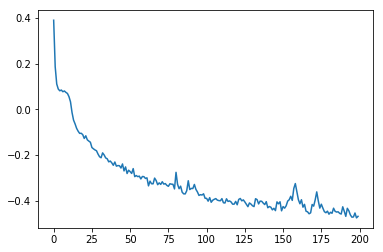

In [19]:
plt.plot(tr_loss)
plt.show()

## Bake masks

In [ ]:
msks = [os.path.basename(x) for x in glob.glob(root_dir + 'masks/*.png')]
imgs = [os.path.basename(x).split('_mrk') for x in msks]
imgs = [x[0] + x[1] for x in imgs]

In [ ]:
def get_mask(img):
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (img[i,j,0] == 0 and img[i,j,1] == 255 and img[i,j,2] == 0):
                mask[i,j] = 1.0
    return mask

In [10]:
for mask in msks:
    bin_name = root_dir + 'masks/' + mask.split('_mrk.png')[0] + '.npy'
    with open(bin_name, 'wb') as fp:
        np.save(fp, get_mask(cv2.imread(root_dir + 'masks/' + mask)))